# Employment number data analysis
Felix Zaussinger | 02.09.2021

## Core Analysis Goal(s)
1. Create employment number + share estimates for FR, UK, IT from 2014-2018 at ISCO-08 4-digit level
2. Analyse the evolution of green, brown and neutral employment over time and per country
3.

## Key Insight(s)
1.
2.
3.

In [3]:
import os
import sys
import logging
from pathlib import Path

import numpy as np
import scipy as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("ticks")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Define directory structure

In [4]:
# project directory
abspath = os.path.abspath('')
project_dir = str(Path(abspath).parents[0])

# sub-directories
data_raw = os.path.join(project_dir, "data", "raw")
data_interim = os.path.join(project_dir, "data", "interim")
data_processed = os.path.join(project_dir, "data", "processed")
figure_dir = os.path.join(project_dir, "reports", "figures")

Example for UK

In [18]:
df_metadata = pd.read_csv(
    os.path.join(data_interim, "ESCO_ONET_METADATA_gbn.csv"),
    index_col=0
)

df_metadata["occ_type"] = df_metadata[["is_brown", "is_neutral", "is_green"]].idxmax(axis=1)

df_metadata.groupby("occ_type").sum().employment_count / df_metadata.employment_count.sum()

occ_type
is_brown      0.043243
is_green      0.110050
is_neutral    0.846708
Name: employment_count, dtype: float64

#### Create data series for UK, FR, IT over 2014-2018

Source: https://github.com/nestauk/mapping-career-causeways/blob/main/codebase/notebooks/03_link_occupational_data/Link_occupations_to_UK_employment.ipynb

In [19]:
# Import all ESCO occupations
occ = pd.read_csv(os.path.join(data_raw, "mcc_data", "processed", "ESCO_occupational_hierarchy", "ESCO_occupational_hierarchy.csv"))

,id,concept_type,concept_uri,preferred_label,isco_level_1,isco_level_2,isco_level_3,isco_level_4,is_top_level,is_second_level,is_third_level,is_fourth_level,parent_occupation_id,top_level_parent_id
0,0,Occupation,http://data.europa.eu/esco/occupation/00030d09...,technical director,2,21,216,2166,False,True,False,False,2408.0,2408
1,1,Occupation,http://data.europa.eu/esco/occupation/000e93a3...,metal drawing machine operator,8,81,812,8121,True,False,False,False,NaN,1
2,2,Occupation,http://data.europa.eu/esco/occupation/0019b951...,precision device inspector,7,75,754,7543,False,True,False,False,1173.0,1173
3,3,Occupation,http://data.europa.eu/esco/occupation/0022f466...,air traffic safety technician,3,31,315,3155,True,False,False,False,NaN,3
4,4,Occupation,http://data.europa.eu/esco/occupation/002da35b...,hospitality revenue manager,2,24,243,2431,True,False,False,False,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2937,2937,Occupation,http://data.europa.eu/esco/occupation/ff656b3a...,demographer,2,21,212,2120,True,False,False,False,NaN,2937
2938,2938,Occupation,http://data.europa.eu/esco/occupation/ff8d4065...,sorter labourer,9,96,961,9612,True,False,False,False,NaN,2938
2939,2939,Occupation,http://data.europa.eu/esco/occupation/ffa4dd5d...,armoured car guard,5,54,541,5414,False,True,False,False,600.0,600
2940,2940,Occupation,http://data.europa.eu/esco/occupation/ffade2f4...,civil service administrative officer,2,24,242,2422,True,False,False,False,NaN,2940


In [61]:
# Import EU LFS estimates
lfs_estimates_uk = pd.read_csv(
    os.path.join(data_raw, "mcc_data", "supplementary_online_data", "demographic_analysis", "national_count_isco", "uk_breakdown_by_isco_w_risk.csv"),
    na_values="x"
)
lfs_estimates_fra = pd.read_csv(
    os.path.join(data_raw, "mcc_data", "supplementary_online_data", "demographic_analysis", "national_count_isco", "fra_breakdown_by_isco_w_risk.csv"),
    na_values="x"
)
lfs_estimates_ita = pd.read_csv(
    os.path.join(data_raw, "mcc_data", "supplementary_online_data", "demographic_analysis", "national_count_isco", "ita_breakdown_by_isco_w_risk.csv"),
    na_values="x"
)

lfs_estimates = {
    "uk": lfs_estimates_uk,
    "fra": lfs_estimates_fra,
    "ita": lfs_estimates_ita
}

occ

,id,concept_type,concept_uri,preferred_label,isco_level_1,isco_level_2,isco_level_3,isco_level_4,is_top_level,is_second_level,is_third_level,is_fourth_level,parent_occupation_id,top_level_parent_id
0,0,Occupation,http://data.europa.eu/esco/occupation/00030d09...,technical director,2,21,216,2166,False,True,False,False,2408.0,2408
1,1,Occupation,http://data.europa.eu/esco/occupation/000e93a3...,metal drawing machine operator,8,81,812,8121,True,False,False,False,NaN,1
2,2,Occupation,http://data.europa.eu/esco/occupation/0019b951...,precision device inspector,7,75,754,7543,False,True,False,False,1173.0,1173
3,3,Occupation,http://data.europa.eu/esco/occupation/0022f466...,air traffic safety technician,3,31,315,3155,True,False,False,False,NaN,3
4,4,Occupation,http://data.europa.eu/esco/occupation/002da35b...,hospitality revenue manager,2,24,243,2431,True,False,False,False,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2937,2937,Occupation,http://data.europa.eu/esco/occupation/ff656b3a...,demographer,2,21,212,2120,True,False,False,False,NaN,2937
2938,2938,Occupation,http://data.europa.eu/esco/occupation/ff8d4065...,sorter labourer,9,96,961,9612,True,False,False,False,NaN,2938
2939,2939,Occupation,http://data.europa.eu/esco/occupation/ffa4dd5d...,armoured car guard,5,54,541,5414,False,True,False,False,600.0,600
2940,2940,Occupation,http://data.europa.eu/esco/occupation/ffade2f4...,civil service administrative officer,2,24,242,2422,True,False,False,False,NaN,2940


In [74]:
# 1. Redistribute workers from 3-digit ISCO to ESCO occupations
years = ["2014", "2015", "2016", "2017", "2018"]
col_sel = ["id", "concept_uri", "preferred_label", "country", "year", "employment_share", "employment_count"]

dfs = []
for country, df in lfs_estimates.items():
    print(country)
    for year in years:
        print(year)
        n_total = df[year].sum()

        # Distribute equally the number of workers across all lower level occupations
        occupations_employment = occ.copy()

        occupations_employment['employment_share'] = np.nan
        occupations_employment['employment_count'] = np.nan
        occupations_employment['country'] = country
        occupations_employment['year'] = year

        for j, row in df.iterrows():
            occ_rows =  occupations_employment[occupations_employment.isco_level_3==row.isco_code].id.to_list()
            occupations_employment.loc[occ_rows, 'employment_share'] = (row[year]/n_total) / len(occ_rows)
            occupations_employment.loc[occ_rows, 'employment_count'] = (row[year] / len(occ_rows)) * 1000

        # occupations_employment['employment_count'] = np.round(occupations_employment['employment_count'] * 1000)

        dfs.append(occupations_employment[col_sel])

uk
2014
2015
2016
2017
2018
fra
2014
2015
2016
2017
2018
ita
2014
2015
2016
2017
2018


In [75]:
df_employment = pd.concat(dfs)
df_employment = df_employment.reset_index(drop=True)

df_employment.to_csv(
    os.path.join(data_interim, "lfs_employment_data_long.csv")
)

In [76]:
df_employment.groupby(["country", "year"]).sum()

id  employment_share  employment_count
country year                                             
fra     2014  4326211               1.0        26108285.0
        2015  4326211               1.0        26168733.0
        2016  4326211               1.0        26330999.0
        2017  4326211               1.0        26646599.0
        2018  4326211               1.0        26751036.0
ita     2014  4326211               1.0        22021132.0
        2015  4326211               1.0        22194319.0
        2016  4326211               1.0        22501998.0
        2017  4326211               1.0        22762242.0
        2018  4326211               1.0        22946395.0
uk      2014  4326211               1.0        30525166.0
        2015  4326211               1.0        31067628.0
        2016  4326211               1.0        31521655.0
        2017  4326211               1.0        31858537.0
        2018  4326211               1.0        32151679.0

In [85]:
df_employment_gbn = pd.merge(
    df_employment,
    df_metadata[["concept_uri", "occ_type"]],
    on="concept_uri",
    how="left"
)

# 21 * 5 * 3 missing military occupations (all neutral)
df_employment_gbn["occ_type"] = df_employment_gbn["occ_type"].fillna("is_neutral")

0

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

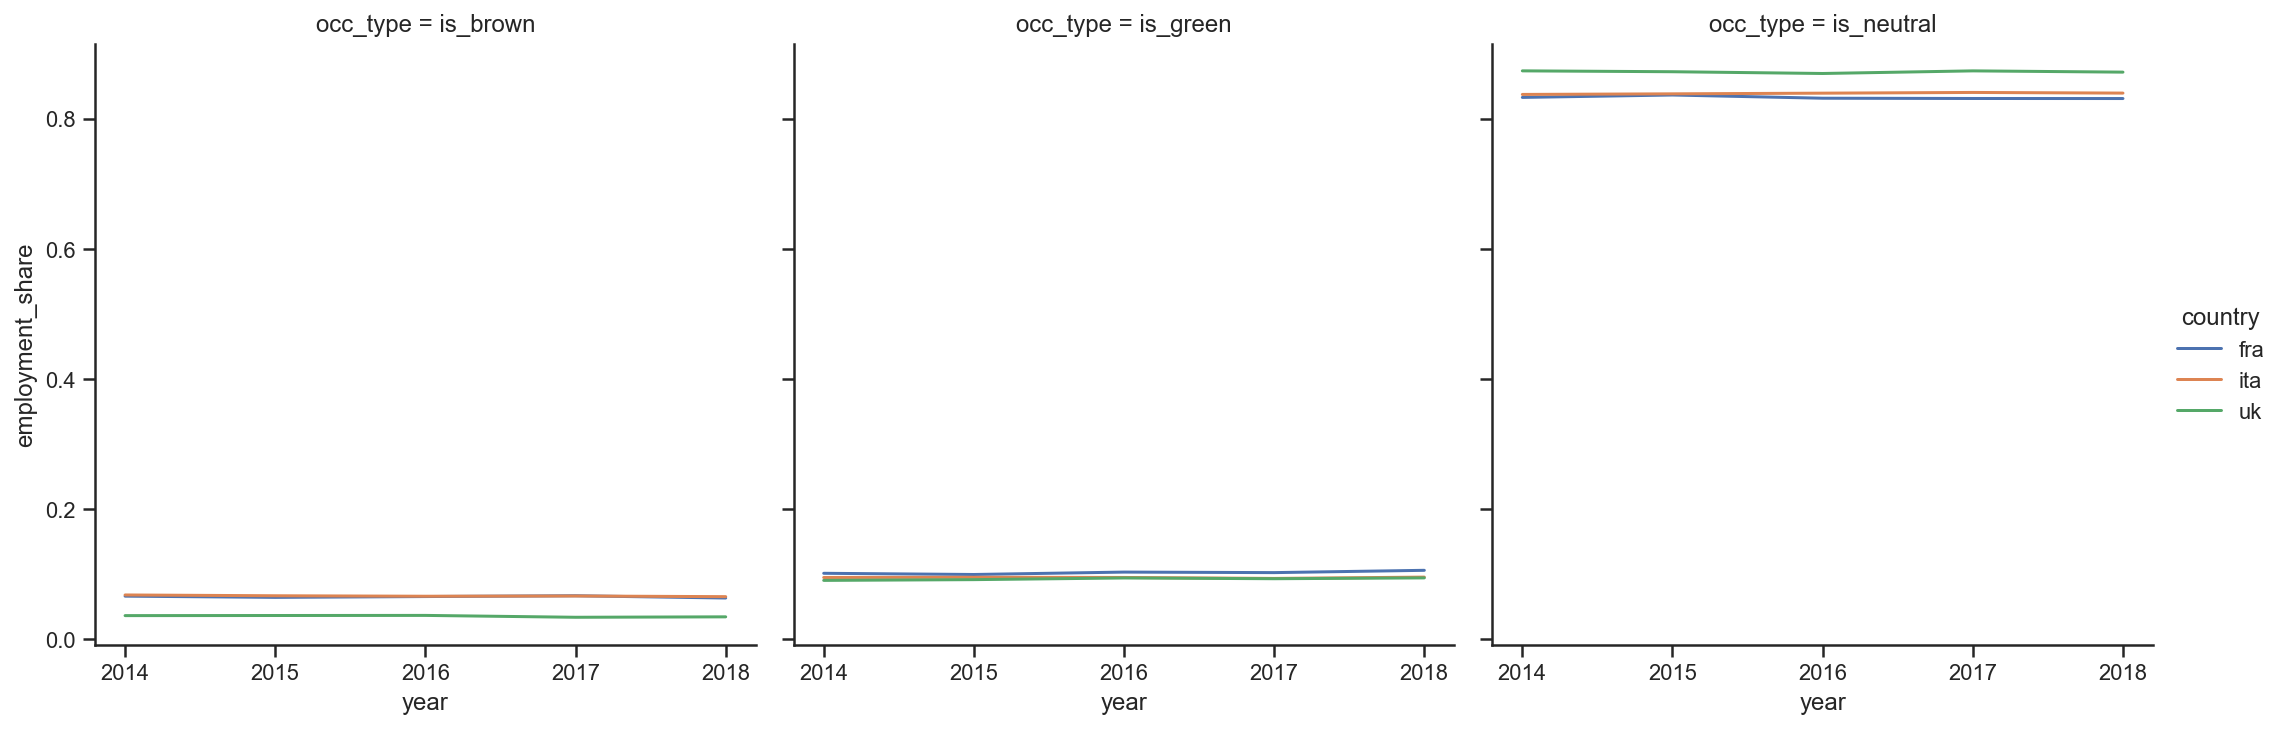

In [105]:
df_res = df_employment_gbn.groupby(["country", "occ_type", "year"]).sum()

sns.relplot(
    data=df_res.reset_index(),
    x="year",
    y="employment_share",
    hue="country",
    col="occ_type",
    kind="line"
)

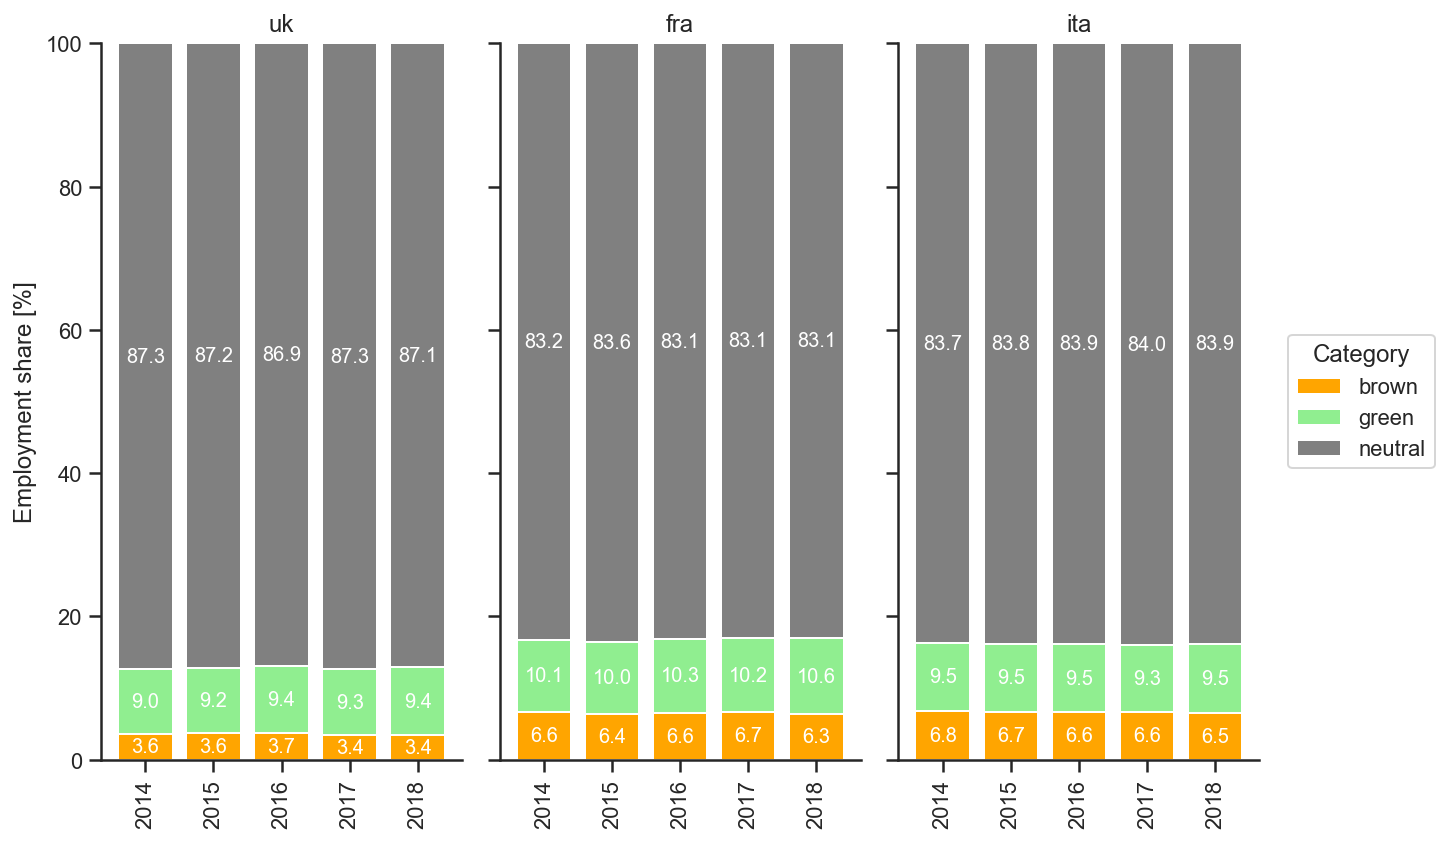

In [165]:
df_res_long = df_res.reset_index()

fig, axes = plt.subplots(figsize=(10, 6), ncols=3, sharey=True, sharex=True)

for country, ax in zip(list(lfs_estimates.keys()), axes):
    df_res_long_bar = df_res_long[df_res_long.country == country].pivot(index='year', columns='occ_type', values='employment_share') * 100
    df_res_long_bar = df_res_long_bar.rename(columns={"is_green": "green", "is_brown": "brown", "is_neutral": "neutral"})
    df_res_long_bar.plot.bar(
        stacked=True,
        color=["orange", "lightgreen", "grey"],
        ax=ax,
        title=country,
        legend=False,
        width=0.8
    )

    ax.set_ylim(0, 100)
    ax.set_xlabel(None)

    # annotate
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        ax.text(x+width/2,
                y+height/2,
                '{:.1f}'.format(height),
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=10,
                color="white")

plt.legend(title='Category', bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.tight_layout()
sns.despine()
axes[0].set_ylabel("Employment share [%]")

plt.savefig(
    os.path.join(figure_dir, "employment", "gbn_share_comparison.png"),
    bbox_inches="tight",
    dpi=300
)